<h1> Naive Bayes Implementation (Gaussian And Categorical) </h1>

In [190]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [191]:
def get_dataframe(filename="irisTraining.txt",header=None,delimiter=" "):
    """This function reads the data from given files and return a pandas datafram object.
    
    Args:
        filename(string): The name of file that contains dataset
        header: Header of the file
        delimiter(string): the character that sperates columns of data
    Returns:
        pandas dataframe: A pandas datafram object containing the data from the filename
    """
    dataframe_df = pd.read_csv(filename,sep=delimiter,header=header) #read files
    return dataframe_df #return dataframe

In [192]:
iris_train_df = get_dataframe(filename="datasets/irisTraining.txt",header=None,delimiter=" ")
iris_train_df

,0,1,2,3,4
0,5.9,-1.0,4.2,1.5,1
1,6.9,-1.1,4.9,1.5,1
2,6.6,-1.9,4.6,1.3,1
3,4.6,-1.2,1.4,0.2,-1
4,6.0,-1.2,4.0,1.0,1
...,...,...,...,...,...
95,7.4,-1.8,6.1,1.9,-1
96,4.9,-1.4,-1.3,1.0,1
97,7.0,-1.2,4.7,1.4,1
98,5.5,-1.4,-1.7,1.0,1


## Implementation of Gaussian Naive Bayes Algorithm

In [193]:
class GaussianNaiveBayes():
    def __init__(self):
        self.__features_mean = {}
        self.__features_sdevs = {}
        self.__unique_labels = []
        self.__trainset_df = None
        self.__prior_probabilities = {}
        
    def get_labels(self):
        return self.__unique_labels
    
    def fit(self,train_data_df):
        """ THis function computes gaussian likehood 
        """
        #set train set for model
        self.__trainset_df = train_data_df.copy()
        
        #  label column
        label_column = list(self.__trainset_df.columns)
        label_column = label_column[len(label_column)-1]
        labels = train_data_df[label_column].to_numpy() #get labels for prior cacluations
        total_count = len(labels)
        
        # get list of class labels
        self.__unique_labels = set(self.__trainset_df[label_column])
        
        #caclulate gaussian parameters
        for label in self.__unique_labels:
            
            # calcuate means and standard deviations
            self.__features_mean[label] = list(self.__trainset_df[self.__trainset_df[label_column]==label].mean()) #get mean for specified classlabel  
            self.__features_sdevs[label] = list(self.__trainset_df[self.__trainset_df[label_column]==label].std()) #get standard deviation for specified classlabel    
    
            #mean and standard deviation for label coumn is not required so drop then
            self.__features_mean[label].pop()
            self.__features_sdevs[label].pop()
            
            #prior probabity calculations
            label_count = len(labels[labels==label])
            prior = (label_count * 1.0) / (total_count * 1.0)
            self.__prior_probabilities[label] = prior


    def print_model_parameters(self):
        print("Classes: ",self.__unique_labels)
        print("")
        print("Means : ", self.__features_mean)
        print("")
        print("Standard Deviations: ",self.__features_sdevs)
        print("")
        print("Prior Probabilities: ", self.__prior_probabilities)
        
    
    def predict_probabilities(self,test_set_df):
        """
        """
        column_names = test_set_df.columns
        label_column = len(column_names) - 1
        feature_matrix = test_set_df.drop([label_column],axis=1)
        feature_matrix = feature_matrix.to_numpy()
        labels_list = []
        probabilities = []
        
        # calculate gaussain likelihoods
        for label in self.__unique_labels:
            cur_matrix = feature_matrix - np.array(self.__features_mean[label])
            cur_matrix = cur_matrix **2
            cur_matrix = cur_matrix / (2 * (np.array(self.__features_sdevs[label])**2) )
            cur_matrix = np.exp((-1 * cur_matrix))
            cur_matrix = cur_matrix * (1.0/np.sqrt(2*np.pi*(np.array(self.__features_sdevs[label]))))
            
            if cur_matrix.ndim > 1:
                cur_matrix = np.prod(cur_matrix,axis=1)
            else:
                cur_matrix = np.prod(cur_matrix)
            
            #multiply by prior probabilities
            cur_matrix = cur_matrix * self.__prior_probabilities[label]
            
            labels_list.append(label)
            probabilities.append(cur_matrix)
        
        # make probabilities into single dataframe
        probabilities_df = pd.DataFrame(probabilities) #convert to dataframe
        probabilities_df = probabilities_df.transpose()
        probabilities_df.columns = labels_list #add labels
        return probabilities_df
    
    def predict_labels(self,test_set_df):
        probabilities_df = self.predict_probabilities(test_set_df)
        labels_list = probabilities_df.columns
        probabilities_df = probabilities_df.to_numpy()
        max_index = np.argmax(probabilities_df,axis=1) #get maximum of each row, axis= 1 horizontal, max each row
        return np.array(labels_list[max_index])
        
    def evaluate(self,test_set_df):
        column_names = test_set_df.columns
        label_column = len(column_names) - 1
        actual_labels = test_set_df[label_column].to_numpy()
        predicted_labels = self.predict_labels(test_set_df)
        #print("1",len(predicted_labels[predicted_labels==1]))
        #print("-1",len(predicted_labels[predicted_labels==-1]))
        agreement =  ( (1.0 * sum(actual_labels == predicted_labels)) / (1.0 * len(predicted_labels)) ) * 100
        print("Model Accuracy: %0.3f%%"%agreement)
        return agreement

In [194]:
model = GaussianNaiveBayes()

In [195]:
model.fit(iris_train_df)

In [196]:
model.print_model_parameters()

Classes:  {1, -1}

Means :  {1: [5.847058823529412, -1.388235294117647, 3.005882352941176, 1.3], -1: [5.771212121212121, -1.3181818181818181, 3.548484848484849, 0.22272727272727275]}

Standard Deviations:  {1: [0.5124127681076908, 0.3198150089171844, 2.5404534523024638, 0.21602468994692867], -1: [0.9419725868157492, 0.7743799685324615, 2.080328555725489, 1.091617776801647]}

Prior Probabilities:  {1: 0.34, -1: 0.66}


In [197]:
sindex = 0
eindex = 5
test = iris_train_df.iloc[sindex:eindex]
print(test)
print("")
df = model.predict_probabilities(test)
df

     0    1    2    3  4
0  5.9 -1.0  4.2  1.5  1
1  6.9 -1.1  4.9  1.5  1
2  6.6 -1.9  4.6  1.3  1
3  4.6 -1.2  1.4  0.2 -1
4  6.0 -1.2  4.0  1.0  1



,1,-1
0,7.975071e-03,0.005679
1,1.142966e-03,0.002487
2,2.227253e-03,0.003597
3,2.397189e-09,0.003476
4,8.157332e-03,0.009449


In [198]:
model.predict_labels(test)

array([ 1, -1, -1, -1, -1], dtype=int64)

In [199]:
model.evaluate(iris_train_df)

Model Accuracy: 89.000%


89.0

In [200]:
iris_train_df[4].to_numpy()

array([ 1,  1,  1, -1,  1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1,
        1, -1, -1, -1, -1, -1,  1, -1, -1,  1, -1, -1, -1, -1, -1, -1,  1,
        1,  1,  1, -1,  1, -1,  1,  1, -1, -1,  1, -1, -1,  1, -1, -1,  1,
       -1, -1, -1, -1, -1, -1, -1,  1,  1, -1, -1, -1, -1,  1,  1, -1, -1,
       -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1,  1, -1,  1,  1, -1,  1,
        1,  1, -1, -1, -1, -1, -1, -1,  1, -1, -1,  1,  1,  1,  1],
      dtype=int64)

In [201]:
model.predict_labels(iris_train_df)

array([ 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1,
        1, -1, -1, -1, -1, -1,  1, -1, -1,  1, -1, -1, -1, -1, -1, -1,  1,
        1,  1, -1, -1,  1, -1,  1,  1, -1, -1,  1, -1, -1,  1, -1, -1,  1,
       -1, -1, -1, -1, -1, -1, -1,  1,  1,  1, -1, -1, -1,  1,  1, -1, -1,
       -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1,  1, -1,  1,  1],
      dtype=int64)

In [202]:
iris_test_df = get_dataframe(filename="datasets/irisTesting.txt",header=None,delimiter=" ")

In [203]:
model.evaluate(iris_test_df)

Model Accuracy: 86.000%


86.0

In [204]:
predicted = model.predict_labels(iris_test_df)
predicted

array([-1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1,  1, -1, -1,
        1, -1,  1, -1, -1, -1,  1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1,  1, -1,  1, -1, -1,  1, -1, -1, -1,  1, -1, -1, -1],
      dtype=int64)

In [205]:
actual = iris_test_df[4].to_numpy()
actual

array([ 1,  1, -1, -1,  1, -1, -1, -1, -1, -1,  1, -1,  1, -1,  1, -1, -1,
       -1, -1,  1, -1, -1,  1,  1, -1, -1,  1, -1,  1, -1, -1, -1, -1, -1,
       -1, -1, -1,  1, -1,  1, -1, -1,  1,  1, -1, -1,  1, -1, -1, -1],
      dtype=int64)

In [206]:
model.get_labels()

{-1, 1}

In [207]:
def binary_confusion_matrix(actual_labels,predicted_labels):
    true_positives = 0
    false_negatives = 0
    true_negatives = 0
    false_positives = 0
    for i in range(0,len(actual_labels)):
        if actual_labels[i]==1:
            if actual_labels[i] == predicted_labels[i]: #1 = 1
                true_positives += 1
            else: #1 != -1
                false_negatives += 1
        else: 
            if actual_labels[i] == predicted_labels[i]: #0 = 0
                true_negatives += 1
            else: #1 != -1
                false_positives += 1
    
    confusion_matrix = np.squeeze(np.array([[true_positives,false_negatives],[false_positives,true_negatives]]))
    #print(cm)
    plt.clf()
    #plt.imshow(cm, interpolation='nearest', cmap=plt.cm.inferno)
    plt.imshow(confusion_matrix, cmap=plt.cm.inferno)
    classNames = ['Positive','Negative']
    plt.title("Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TP','FN'], ['FP', 'TN']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i,str(s[i][j])+"="+str(confusion_matrix[i][j]),color="r",fontsize=12)
    plt.show()
    return confusion_matrix


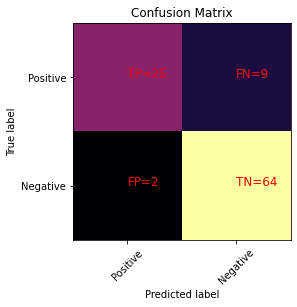

array([[25,  9],
       [ 2, 64]])

In [208]:
binary_confusion_matrix(iris_train_df[4].to_numpy(),model.predict_labels(iris_train_df))

In [209]:
def binary_aprf(actual_labels,predicted_labels):
    true_positives = 0
    false_negatives = 0
    true_negatives = 0
    false_positives = 0
    for i in range(0,len(actual_labels)):
        if actual_labels[i]==1:
            if actual_labels[i] == predicted_labels[i]: #1 = 1
                true_positives += 1
            else: #1 != -1
                false_negatives += 1
        else: 
            if actual_labels[i] == predicted_labels[i]: #0 = 0
                true_negatives += 1
            else: #1 != -1
                false_positives += 1
                
    accuracy = ((true_positives + true_negatives) *1.0) / (1.0 * (true_positives + true_negatives + false_negatives + false_positives) )
    precision = (true_positives * 1.0) / ( (true_positives + false_positives)* 1.0)
    recall = (true_positives * 1.0) / ( (true_positives + false_negatives)* 1.0)
    f_measure = (2.0 * true_positives) / (1.0 * ( (2.0 * true_positives) + false_positives + false_negatives ) )
    print("Accuracy: %0.2f"%accuracy)
    print("Precision: %0.2f"%precision)
    print("Recall: %0.2f"%recall)
    print("F-Measure: %0.2f"%f_measure)

In [210]:
binary_aprf(iris_train_df[4].to_numpy(),model.predict_labels(iris_train_df))

Accuracy: 0.89
Precision: 0.93
Recall: 0.74
F-Measure: 0.82


In [211]:
binary_aprf(iris_test_df[4].to_numpy(),model.predict_labels(iris_test_df))

Accuracy: 0.86
Precision: 0.91
Recall: 0.62
F-Measure: 0.74


## Implementation of Categorical Naive Bayes Algorithm

In [212]:
buy_train_df = get_dataframe(filename="datasets/buyTraining.txt",header=None,delimiter=" ")
buy_train_df

,0,1,2,3,4
0,1,3,2,1,-1
1,1,3,2,2,-1
2,2,3,2,1,1
3,3,2,2,1,1
4,3,1,1,1,1
5,3,1,1,2,-1
6,2,1,1,2,1
7,1,2,2,1,-1
8,1,1,1,1,1
9,3,2,1,1,1


In [213]:
class CategoricalNaiveBayes():

    def __init__(self):
        self.__unique_labels = ()
        self.__label_frequencies = {}
        self.__category_frequencies = {}
        self.__prior_probabilities = {}
        self.__posterior_probabilities = {}
        self.__featurewise_unique_count = {}
        self.__trainset_df = None
        
    
    def print_parameters(self):
        print("Classes: ", self.__unique_labels)
        print("")
        print("Feature Wise Unique Count: ", self.__featurewise_unique_count)
        print("")
        print("Class Frequencies: ",self.__label_frequencies)
        print("")
        print("Category Frequencies: ",self.__category_frequencies)
        print("")
        print("Prior Probabilities: ",self.__prior_probabilities)
        print("")
        for key_pair in self.__posterior_probabilities.keys():
            print(key_pair," : ",self.__posterior_probabilities[key_pair])
        #print("Posterior Probabilities: \n",self.__posterior_probabilities)


    def fit(self,train_set_df):
        
        #convert from datafram to numpy
        feature_matrix= train_set_df.to_numpy()
        
        #compute label frequencies and prior probabilities
        label_column = list(train_set_df.columns)
        label_column = label_column[len(label_column)-1]
        self.__unique_labels = list(set(train_set_df[label_column])) # get list of class labels
        
        #compute label frequencies and prior probabilities
        total_labels = len(train_set_df[label_column]) #total count of labels 
        for label in self.__unique_labels:
            freq = len(buy_train_df[buy_train_df[label_column]==label][label_column])
            self.__label_frequencies[label] = freq #compute label frequency
            self.__prior_probabilities[label] = (1.0 * freq) / (total_labels * 1.0) #compute prior probabiity
        
        #create a hastable that has counts of feature-value given class
        for i in range(0,feature_matrix.shape[0]):
            for j in range(0,feature_matrix.shape[1]-1):
                attribute = j 
                category = feature_matrix[i,j]
                label = feature_matrix[i,feature_matrix.shape[1]-1]
                key_pair = (attribute,category,label)
                if key_pair not in self.__category_frequencies:
                    self.__category_frequencies[key_pair] = 1
                else:
                    self.__category_frequencies[key_pair] += 1
                    
        #count number of unique values per feature, as required by laplacian smoothing
        for col in range(0,feature_matrix.shape[1]-1):
            self.__featurewise_unique_count[col] = len(set(feature_matrix[:,col]))
        
        #numberator constant to prevent probabiliity of zero, as required by laplacian smoothing
        laplacian_smoothing_constant = 1
        
        #compute posterior likelihood and include laplacian smoothing
        for key_pair in self.__category_frequencies.keys():
            for label in self.__unique_labels:
                if label == key_pair[2]:
                    posterior_prob_numerator = self.__category_frequencies[key_pair] + laplacian_smoothing_constant
                    posterior_prob_denominator = self.__label_frequencies[key_pair[2]]+ self.__featurewise_unique_count[key_pair[0]]
                    posterior_prob = (1.0 * posterior_prob_numerator)  / (1.0 * posterior_prob_denominator)
                    self.__posterior_probabilities[key_pair] = posterior_prob #save the posteriro probability
                    
                elif (key_pair[0],key_pair[1],label) not in self.__posterior_probabilities.keys():
                    posterior_prob_numerator = 0 + laplacian_smoothing_constant
                    posterior_prob_denominator = self.__label_frequencies[label]+ self.__featurewise_unique_count[key_pair[0]]
                    posterior_prob = (1.0 * posterior_prob_numerator)  / (1.0 * posterior_prob_denominator)
                    self.__posterior_probabilities[(key_pair[0],key_pair[1],label)] = posterior_prob

                    
    def predict_probabilities(self,test_set_df):
        #get column
        label_column = list(test_set_df.columns)
        label_column = label_column[len(label_column)-1]
        feature_matrix = test_set_df.to_numpy() #convert to numpy
        predicted_probailities = [] #predcited probabilities
        for i in range(0,feature_matrix.shape[0]):
            row_probs = np.zeros(len(self.__unique_labels))
            for j in range(0,feature_matrix.shape[1]-1):
                attribute = j
                category = feature_matrix[i,j]
                label_wise_prob = []
                for k in range(0,len(self.__unique_labels)):
                    key_pair = (attribute,category,self.__unique_labels[k])
                    posterior_prob = self.__posterior_probabilities[key_pair]
                    if j == 0:
                        row_probs[k] = posterior_prob * self.__prior_probabilities[self.__unique_labels[k]]
                    else:
                        row_probs[k] *= posterior_prob
            predicted_probailities.append(row_probs)
            
        predicted_probailities = np.squeeze(np.array(predicted_probailities))
        predicted_probailities = pd.DataFrame(predicted_probailities)
        predicted_probailities.columns = self.__unique_labels
        #print(predicted_probailities)
        return predicted_probailities
        
        
    def predict_labels(self,test_set_df):
        probabilities_df = self.predict_probabilities(test_set_df)
        labels_list = probabilities_df.columns
        probabilities_df = probabilities_df.to_numpy()
        max_index = np.argmax(probabilities_df,axis=1) #get maximum of each row, axis= 1 horizontal, max each row
        return np.array(labels_list[max_index])
    
    def evaluate(self,test_set_df):
        column_names = test_set_df.columns
        label_column = len(column_names) - 1
        actual_labels = test_set_df[label_column].to_numpy()
        predicted_labels = self.predict_labels(test_set_df)
        #print("1",len(predicted_labels[predicted_labels==1]))
        #print("-1",len(predicted_labels[predicted_labels==-1]))
        agreement =  ( (1.0 * sum(actual_labels == predicted_labels)) / (1.0 * len(predicted_labels)) ) * 100
        print("Model Accuracy: %0.3f%%"%agreement)
        return agreement

In [216]:
cat_model = CategoricalNaiveBayes()

In [217]:
cat_model.fit(buy_train_df)

In [218]:
cat_model.print_parameters()

Classes:  [1, -1]

Feature Wise Unique Count:  {0: 3, 1: 3, 2: 2, 3: 2}

Class Frequencies:  {1: 9, -1: 5}

Category Frequencies:  {(0, 1, -1): 3, (1, 3, -1): 2, (2, 2, -1): 4, (3, 1, -1): 2, (3, 2, -1): 3, (0, 2, 1): 4, (1, 3, 1): 2, (2, 2, 1): 3, (3, 1, 1): 6, (0, 3, 1): 3, (1, 2, 1): 4, (1, 1, 1): 3, (2, 1, 1): 6, (0, 3, -1): 2, (1, 1, -1): 2, (2, 1, -1): 1, (3, 2, 1): 3, (1, 2, -1): 1, (0, 1, 1): 2}

Prior Probabilities:  {1: 0.6428571428571429, -1: 0.35714285714285715}

(0, 1, 1)  :  0.25
(0, 1, -1)  :  0.5
(1, 3, 1)  :  0.25
(1, 3, -1)  :  0.375
(2, 2, 1)  :  0.36363636363636365
(2, 2, -1)  :  0.7142857142857143
(3, 1, 1)  :  0.6363636363636364
(3, 1, -1)  :  0.42857142857142855
(3, 2, 1)  :  0.36363636363636365
(3, 2, -1)  :  0.5714285714285714
(0, 2, 1)  :  0.4166666666666667
(0, 2, -1)  :  0.125
(0, 3, 1)  :  0.3333333333333333
(0, 3, -1)  :  0.375
(1, 2, 1)  :  0.4166666666666667
(1, 2, -1)  :  0.25
(1, 1, 1)  :  0.3333333333333333
(1, 1, -1)  :  0.375
(2, 1, 1)  :  0.6363636

In [219]:
buy_train_df.iloc[0:4]

,0,1,2,3,4
0,1,3,2,1,-1
1,1,3,2,2,-1
2,2,3,2,1,1
3,3,2,2,1,1


In [220]:
cat_model.predict_probabilities(buy_train_df.iloc[0:4])

,1,-1
0,0.009298,0.020499
1,0.005313,0.027332
2,0.015496,0.005125
3,0.020661,0.010250


In [221]:
cat_model.evaluate(buy_train_df)

Model Accuracy: 85.714%


85.71428571428571

In [222]:
buy_test_df = get_dataframe(filename="datasets/buyTesting.txt",header=None,delimiter=" ")
buy_test_df

,0,1,2,3,4
0,3,2,1,1,-1
1,3,2,1,2,1
2,1,2,2,2,-1
3,1,1,1,1,1


In [223]:
cat_model.predict_probabilities(buy_test_df)

,1,-1
0,0.036157,0.004100
1,0.020661,0.005466
2,0.008855,0.018222
3,0.021694,0.008200


In [224]:
cat_model.predict_labels(buy_test_df)

array([ 1,  1, -1,  1], dtype=int64)

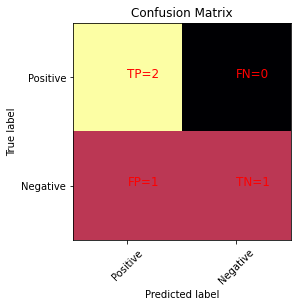

array([[2, 0],
       [1, 1]])

In [225]:
binary_confusion_matrix(buy_test_df[4].to_numpy(),cat_model.predict_labels(buy_test_df))